# COGS 108 - Capstone Project

# [ Introduction and Background ]

San Diego has always had very diverse demographics. With a population of over 3 million in the urban district (https://en.wikipedia.org/wiki/San_Diego#Demographics) the city is always bustling with people and tourists. Located just above the Mexican border and a major travel destination for Pacific immigrants, almost half of the city’s population are minorities. It comes to our understanding that with a big population comes a big responsibility for enforcing police officers, who have many additional concerns such as illegal immigrants and drug trafficking. We would like to examine whether there is racial bias in police officers when they pull over people in San Diego.
 
The San Diego Police Division strives to make sure that officers provide a high feeling of value and public trust. Such goals include acting professionally and ethically, identifying crime offenders, and supporting an informed workforce (https://www.sandiego.gov/police/about). However, previous reports and files may indicate otherwise. SDSU research found that Hispanics and Africans in San Diego were being more frequently searched and questioned than other racial groups, which eventually received the attention of SDPD (http://www.sandiegouniontribune.com/news/politics/sd-me-police-hearing-20161130-story.html). We want to keep in mind that there are various other factors that could explain a bias in stops, such as the police district where the driver was stopped, the demographics of the county, and the gender of the driver. We decided to further investigate if including additional factors still suggest a potential racial discrepancy with proportion to the police district, and if so what may be causing it.

Hypothesis

Based on the fact that groups such as San Diego Union Tribune have accused the police department of racial bias, we hypothesize that the percentage of stops by race will be higher for races such as Blacks and Hispanics than their percentage of the population, which could be an indication of racial bias. We also hypothesize that Hispanic and Black minorities have a higher chance of receiving citations than other racial groups. Also, based on the criticism the police is receiving, we will see lower citation and arrest rates in the most recent years.

## <font color='Black'>Team Members</font>

Alberto Ochoa – A13573544 - Data Cleaning (Cleaning and Merging), Data Visualization (Graphs), Data Analysis, Conclusion and Discussion

Arthur Tran – A13660401 - Data Cleaning (Lists and Standardizations), Privacy, Ethics

Christian Lay-Geng – A13765266 - Data Cleaning (Zip Code), Introduction, Data Description

Daniel Gordee – A13954957 Data Cleaning (PDF), Data Visualization (Graphs), Data Analysis

Erich McMillan – A13501606 - Data Cleaning (Zip Code), Data Visualization (Map)


# [ Data Description ]

We used three different types of sites to gather information on police vehicle stops, zip code populations, and police districts.
 
We used Data.SanDiego.gov to gather raw information on police stops in the last four years (https://data.sandiego.gov/datasets/police-vehicle-stops/). Data.SanDiego.gov is a publicly sourced website that freely offers government information to communicate more effectively with the general public. From this link we scraped the data of every police stop in San Diego from the last four years into twelve CSV files, which included the stops, race codes, and searches. Amongst these files were other files that explained how to read the data and police terms. Information gathered included the stop cause, race, gender, age, date, residency, and other police actions (such as arrested, searched, and seized), however we are only interested in a few of those attributes. We assume that since it is part of their police report that the officers record the information as accurately as possible. In our project we labeled the police stop CSV files gathered as “vehicle_stops” for 2014 - 2017. In order to read them we had additional files for the race code as “vehicle_stops_race_codes.csv” and possible actions taken as “vehicle_stops_search_detail_description_list.csv”.

To compare the police stops to the broader population we used DataSurfer to gather information on the population per zip code. The website gave us San Diego’s population during the 2010 census split by zip code (http://datasurfer.sandag.org). We wrote a small script called download.ipynb to write into a file the information as a listed PDF inside a folder called “zip_pop_data.” The PDFs have a lot of information breaking down the zip code’s population by race, gender, age, and more. This would eventually be called by our method called “get_zip_info()” to gather the zip code’s population by race and cleaned by various functions. We understand that long distance drivers who are pulled over are not part of the zip code’s population but counted towards that zip code’s stop count, which could alter our calculations. However we are testing the police’s likelihood of stopping someone, so the population acts as the most accurate representation.

When going through the data, we realized that police officers record vehicle stops based on the police district the driver is caught in. However, the population data that we want to compare it to is recorded by postal zip codes. In order to compare the data we needed a way to assign zip codes to a corresponding police district because the distribution of police districts is not identical to zip code districts. We used the San Diego police district’s map of police districts located on their website and compared them to zip code regions in San Diego (https://www.sandiego.gov/sites/default/files/legacy/police/pdf/2013policecitywidemap.pdf , http://www.city-data.com/zipmaps/San-Diego-California.html). To convert them we matched each zip code to a police district and organized it into an Excel sheet. From there we read the information into a dictionary using “get_area_zips(),” which recorded the zip code and weighed how much of the population was located within that police district labeled “vehicle_stops_dictionary.csv.” 


In [1]:
# Imports
%matplotlib inline

# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data analysis
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# Interactable 
from ipywidgets import interactive

# PDF Reading
!pip install PyPDF2
import PyPDF2 as pdf

import requests
import os
import locale

#Some packages for data visualization
import json

!pip install vincent
import vincent
vincent.core.initialize_notebook()

from skimage import io

!pip install folium
import folium
from folium import plugins

C:\Users\atran\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# [ Data Cleaning ]

- There are two types of CSV files for every year that with police stops information. The first one includes information regarding the subject and stop (location, time, date, race, gender, age, and more) as well as a specific ID associated with the stop. The second type includes the information of what the police officer did, that is, the action he took (whether he cited the driver, searched his vehicle, etc.) with the specific ID associated with the stop. 
- First we cleaned the data by getting rid of unwanted columns in the data sets like location, or time of the stop.
- Then we cleared the rows with Nan values in the columns we would analyze since we could not replace the missing values with average values, we cannot guess what someone's race, stop cause, or police action, so we deleted such data.
- The police action dataframe had actions of all types since, for example, 'citation' and 'cited' mean the same thing but are not written the same way, so we parsed all common police actions into keywords. Some police actions happened five or less times per year, so we removed those to make our analysis more compact and avoid dealing with data that would give us insignificant results.
- Once each CSV file is cleaned we merge them based on police ID, however there are some problems that need to be fixed before doing this. In the police action dataframe, some stops have multiple rows associated with them since the police officer took more than one action (citatio, arrest, and search for example). However the Stops information dataset only has one entry per ID, so we encapsulated all actions taken for a single stop in a list, and added that list to a new column in the stops information dataset. That way we merge the information of both dataframes and have only one entry per stop, no duplicates. 

## -> Cleaning stops dataframe - Fuctions
### Clean unwanted columns

In [2]:
# Wanted column titles for stops dataframe
stops_col_titles = ['stop_id','stop_cause','service_area','subject_race','subject_sex','subject_age',
                    'arrested','searched','contraband_found','property_seized']

In [3]:
# Funtion to get rid of unwanted columns in vehicle stop dataset - Alberto
# Params: stops - dataset of stops to clean
def clean_stops_cols(stops):
    
    #Obtain unwated columns and drop them
    drop_list = np.setdiff1d(list(stops),stops_col_titles)
    stops.drop(drop_list, axis=1, inplace=True)
    
    return stops

### Clean NaNs and missing values

In [4]:
#If nans exist of these columns the entry will be dropped
clean_nans_cols = ['stop_cause', 'stop_id', 'subject_race', 'subject_sex', 'subject_age']

In [5]:
# Function to get rid of nans vehicle stop dataset - Alberto
# Params: stops - dataset of stops to clean
def clean_stops_nans(stops):
    
    # Here we assume a Nan means a No in these columns (Since the majority of columns had 'Nan' instead of 'N')
    stops['arrested'] = stops['arrested'].replace({np.nan:'N'})
    stops['searched'] = stops['searched'].replace({np.nan:'N'})
    stops['contraband_found'] = stops['contraband_found'].replace({np.nan:'N'})
    stops['property_seized'] = stops['property_seized'].replace({np.nan:'N'})
    
    stops.dropna(how = 'any', subset = clean_nans_cols, inplace = True)
    
    return stops

## -> Cleaning stops details dataframe - Functions
### Clean unwanted columns of stop details dataset

In [6]:
# Wanted column titles for stops information dataframe
stops_info_col_titles = ['stop_id','search_details_type','search_details_description']

In [7]:
# Funtion to get rid of unwanted columns in vehicle stop informationdataset - Alberto
# Params: stops_info - dataset of stops information to clean
def clean_stops_info_cols(stops_info):
    
    #Obtain unwated columns and drop them
    drop_list = np.setdiff1d(list(stops_info),stops_info_col_titles)
    stops_info.drop(drop_list, axis=1, inplace=True) 
    
    return stops_info

### Clean NaNs and missing values

In [8]:

# Take out meaningless entry
# Params: stops_info - dataset of stops information to clean
def clean_stops_info_meaningless(stops_info):
    
    stops_info = stops_info[~((stops_info['search_details_type'] == 'ActionTakenOther') 
                                      & stops_info['search_details_description'].isnull())]
    stops_info = stops_info[~((stops_info['search_details_type'] == 'ActionTaken') 
                                      & (stops_info['search_details_description'] == 'Other'))]
    stops_info = stops_info[~((stops_info['search_details_type'] == 'SearchBasis') 
                                      & (stops_info['search_details_description'] == 'Other'))]
    return stops_info

In [9]:
# Standarize action type entry
# Params: action - string to be standarized
def standardize_action_type(action_type):
    action_type = str(action_type)
    action_type = action_type.lower()
    
    if 'action' in action_type:
        action_type = 'action'
    
    elif 'search' in action_type:
        action_type = 'search'
        
    return action_type

In [10]:
# Standarize action details entry
# Params: action - string to be standarized
def standardize_action_desc(action):
    
    # Otherwise move onto parsinf
    action = str(action)
    action = action.lower()

    if 'arrest' in action:
        action = ['arrest']
        
    elif '310' in action:
        action = ['310']
        
    elif 'imp' in action:
        action = ['impound']

    elif 'tow' in action:
        action = ['tow']
        
    elif 'mistake' in action:
        action = ['released']
        
    elif 'released' in action:
        action = ['released']
        
    elif 'leave' in action:
        action = ['released']
        
    elif 'free' in action:
        action = ['released']
        
    elif 'no vio' in action:
        action = ['released']
        
    elif 'no dui' in action:
        action = ['released']
        
    elif 'nothing' in action:
        action = ['released']
         
    elif 'notice' in action:
        action = ['suspension notice']
        
    elif 'plate' in action:
        action = ['check plate']
        
    elif 'passenger' in action:
        action = ['passenger']
        
    elif 'license' in action:
        action = ['license']
        
    elif 'dui' in action:
        action = ['dui eval']
        
    elif 'det' in action:
        action = ['detention']
        
    elif 'contact' in action:
        action = ['contact']
        
    elif 'suspen' in action:
        action = ['suspension']
    
    elif 'susp' in action:
        action = ['suspect']
        
    elif 'cit' in action:
        action = ['citation']
        
    elif 'dmv' in action:
        action = ['DMV issue']
        
    elif 'nan' in action:
        action = 'Other'
        
    else:
        action = 'Other'
        
    return action

In [11]:
# Clean nans and reduce descriptions
# Params: stops_info - dataset of stops information to clean
def clean_stops_info_nans(stops_info):
    
    # Clean meaningless columns
    stops_info = clean_stops_info_meaningless(stops_info)
    
    # Clean type column
    type_title = 'search_details_type'
    stops_info[type_title] = stops_info[type_title].apply(standardize_action_type)
    
    # Clean details column
    desc_title = 'search_details_description'
    stops_info[desc_title] = stops_info[desc_title].apply(standardize_action_desc)
    
    # Remove 'Other' and nan entries as they do not give us any extra information
    stops_info = stops_info[~(stops_info['search_details_description'] == "Other")]
    stops_info.dropna(how = 'any', subset = stops_info_col_titles, inplace = True)
    
    return stops_info

## -> Final cleaning functions - Combining it all

In [12]:
# Combine cleaning dataframe functions into one
# Params: stops - stops dataframe to be cleaned
def clean_stops(stops):
    stops = clean_stops_cols(stops)
    stops = clean_stops_nans(stops)
    
    return stops

In [13]:
# Combine cleaning dataframe functions into one
# Params: stops_info - stops information dataframe to be cleaned
def clean_stops_info(stops_info):
    stops_info = clean_stops_info_cols(stops_info)
    stops_info = clean_stops_info_nans(stops_info)
    return stops_info

## -> Merging stops and details dataset

In [14]:
# Helper function: Merges duplicates within the information dataset
# Params: info - dataframe with stops information
def merge_duplicates(info):
    
    deleted = 0
    last_index = len(info) -1

    for index, row in info.iterrows():
    
        if deleted > 0:
            deleted -= 1
        
        elif index < last_index:
        
            s_id = row['stop_id']
        
            next_index = index+1
            next_id = info['stop_id'][next_index]
    
            while (s_id == next_id) & (next_index <= last_index):
            
                # Grab entry of duplicate
                entry = info.loc[next_index, 'search_details_description']
            
                # Append duplicate entry to original
                info.loc[index, 'search_details_description'].append(entry[0])
            
                # Drop duplicate row
                info.drop(next_index, inplace=True)
            
                # Increase index of next row
                next_index += 1
            
                # Check for out of bounds
                if next_index  < last_index:
                    next_id = info['stop_id'][next_index]
                
                deleted += 1
    return info

In [15]:
# Function: Merge the stops and details dataframes
# Params: stops - dataframe with stops information
#          info - dataframe with stop details
def merge_dataframes(stops, info):
    
    
    # Drop type information
    info.drop('search_details_type', axis=1, inplace=True)
    
    # Reset indeces
    info = info.reset_index()
    info.drop('index', axis=1, inplace=True)
    
    # Merge duplicates of information dataset
    info = merge_duplicates(info)
    
    df_merged = stops.merge(info, on = ['stop_id'], how = 'left')
    
    return df_merged

# [ Data Pre-Processing ]

In this section we create functions and list variables that will allow us to process the data. These are the main things we do:
 - Race grouping: There are many letters for individual races, and we must group them to compress our analysis and equate it to the races provided by the census. For example, the census gives us a percentage of the asian population, and the police area gives a different letter for Japanese, Chinese, Vietnamese individuals and more, so we must group them together as Asian.
 - Reading population information from PDF: We read the census population per zip code from the PDF files we downloaded.
 - Zip code to police area: The census information we obtained was split among zip codes, however stop locations came from police area. We visually went through police area one by one and created a dictionary that has the zip codes a police area encapsulates. Sometimes a zip code is divided by two or more police areas, and based on the roads that zip code has in each police area, we calculated what percentage of the zip code lays in the police areas, that way our population information per police area would be as accurate as possible.
 - Dataframes for police areas: We use all of these functions to fill in two datsets per police area, one that contains stop counts for every race and another one that stores population census information.
 - Set-up functions for graphing: We create functions that use the dataframes above to create descriptive and correlating graphs per police area to visualize the data.

## -> Mapping functions and variables

### Mapping of individuals' races

In [16]:
# Function that maps all of the police race data into categories given in census
# Param: race - character correcponding to a race to be assigned
# Return: (Based on census) A = asian, B = black, H = hispanic, I = indian, O = other
def assign_race(race):
    
    if race in ['A','C','D','F','J','K','L','V','I']:
        return 'A'
    
    elif race == 'B':
        return 'B'
    
    elif race == 'H':
        return 'H'
    
    elif race == 'W':
        return 'W'
    
    elif race in ['E','G','M','N','O','P','Q','R','S','T','U','Y','Z']:
        return 'O'
    
    else:
        return 'X'

### Mapping of police area to zip code

In [17]:
# Function that maps zip codes to police areas
def get_area_zips(area):
    code_dict = {'110':list(['92122', '1', '92117', '1', '92111', '0.8', '92110', '0.4' ]),
                '120': list(['92109', '1', '92037', '1']),
                '130': list(['0']),
                '230': list(['92129', '1', '92128', '1', '92127', '0.3', '92025', '0.3']),
                '240': list(['92145', '1', '92126', '1', '92131', '1']),
                '310': list(['92123', '1', '92124', '1', '92108', '1', '92111', '0.2']),
                '320': list(['92120', '1', '92119', '1']),
                '430': list(['92139', '1', '92114', '1']),
                '440': list(['92136', '1', '92102', '0.4', '92113', '0.5']),
                '510': list(['92113', '0.5', '92102', '0.6']),
                '520': list(['92101', '1']),
                '530': list(['0']),
                '610': list(['92107', '1', '92106', '1', '92140', '1', '92110', '0.6']),
                '620': list(['92103', '1']),
                '630': list(['0']),
                '710': list(['92173', '1', '92154', '0.4']),
                '720': list(['92154', '0.6']),
                '810': list(['92104','1','92116','0.4']),
                '820': list(['92115', '1', '92116', '0.6']),
                '830': list(['92105', '0.8']),
                '840': list(['0']),
                '930': list(['92121', '1', '92130', '1', '92014', '1', '92091', '1', '92127', '0.7']),
                'Unknown': list(['0'])
                }
    return code_dict[area]

### List of possible police actions taken

In [18]:
# List of actions that can appear in merged stops dataframes 
actions = list(['arrest', '310', 'impound', 'tow', 'released', 'suspension notice', 'check plate', 'passenger',
                'license', 'dui eval', 'detention', 'contact', 'suspension', 'suspect', 'citation', 'DMV issue', 
                'other', 'NaN', 'total'])

observed_actions = ['arrest', '310', 'impound', 'tow', 'released', 'suspension notice', 'check plate', 'passenger',
                        'license', 'dui eval', 'detention', 'contact', 'suspension', 'suspect', 'citation', 'DMV issue']

### List of years

In [19]:
years_list = ['2017', '2016', '2015', '2014']

### List of police codes

In [20]:
areas_codes_list = ['110','120','230','240','310','320','430','440','510','520','610','620','710','720','820','810','830','930']

In [21]:
# these areas have relevant stop data and zip code data
# *omitted areas include parks, military bases, etc.
areas_with_data = ['110','120','230','240','310','320','430','440','510','520','610','620','710','720','820','830','930']

### List of races

In [22]:
# Races that make up the majority of the san diego area
races = list(['W', 'H', 'A', 'B'])

## -> PDF Reading

### Get population percentages by race

In [23]:
# Function to get population data from a specific zip code
# Params: code: zip code to be extracted
#         percent: percentage of the population of the zip code you are looking into
def get_zip_info(code, percent):
    locale.setlocale(locale.LC_ALL, '')
    currDir = 'zip_pop_data/'
    try:
        file = currDir + code + '.pdf'
        fpdf = pdf.PdfFileReader(file)
        page = fpdf.getPage(0).extractText()

        # Gets the beginning and end of the data we want
        index = page.find('Population\nPercent\nTotal Population')
        indexEnd = page.find('Source: SANDAG, Current Estimates (2010)\nPopulation by Race')
        text = page[index+19:indexEnd-1]
        text = list(text)
        for index, item in enumerate(text):
            if item == "\n":
                text[index] = '/'

        text = ''.join(text)
        text = text.split('/')
        groups = list()
        percentages = list()
        populations = list()
        cols = ['Group', 'Population', 'Percent']

        for item in text:
            if '%' in item:
                percentages.append(item)
            elif item[0].isnumeric():
                populations.append(locale.atoi(item) * np.float(percent))
            else:
                groups.append(item) 

        p_df = pd.DataFrame(columns = cols)
        p_df['Group'] = groups
        p_df['Population'] = populations
        p_df['Percent'] = percentages
        p_df.set_index('Group', inplace=True)
        p_df = p_df.reindex(["Total Population", "White", "Hispanic", "Asian", "Black", "Two or More", "American Indian",
                    "Pacific Islander", "Other"])
        p_df.fillna(0.0, inplace=True)
        
        # Makes sure that each value in percent column has a % sign on it - fixes errors caused by null
        
        for index, row in p_df.iterrows():
            if '%' not in str(row['Percent']):
                p_df.loc[index, 'Percent'] = str(row['Percent']) + '%'
        return p_df
    except PermissionError:
        print('error')

In [24]:
print(get_zip_info('92122', '1'))

                  Population Percent
Group                               
Total Population     43382.0    100%
White                23612.0     54%
Hispanic              4083.0      9%
Asian                13321.0     31%
Black                  635.0      1%
Two or More           1464.0      3%
American Indian         56.0     <1%
Pacific Islander        72.0     <1%
Other                  139.0     <1%


## -> Building data-structures for analysis

### Dataframe to hold information about actions and population for every police area

In [25]:
# Function - Sets up police area dictionary for a given year
# Return: Dictionary where each police code has two empty dataframes
#         The dataframes will correspond to police actions per race and population percentages for each area
def get_year_areas():
    df_areas = {
        '110': [pd.DataFrame(), pd.DataFrame()],
        '120': [pd.DataFrame(), pd.DataFrame()],
        '130': [pd.DataFrame(), pd.DataFrame()],
        '230': [pd.DataFrame(), pd.DataFrame()],
        '240': [pd.DataFrame(), pd.DataFrame()],
        '310': [pd.DataFrame(), pd.DataFrame()],
        '320': [pd.DataFrame(), pd.DataFrame()],
        '430': [pd.DataFrame(), pd.DataFrame()],
        '440': [pd.DataFrame(), pd.DataFrame()],
        '510': [pd.DataFrame(), pd.DataFrame()],
        '520': [pd.DataFrame(), pd.DataFrame()],
        '530': [pd.DataFrame(), pd.DataFrame()],
        '610': [pd.DataFrame(), pd.DataFrame()],
        '620': [pd.DataFrame(), pd.DataFrame()],
        '630': [pd.DataFrame(), pd.DataFrame()],
        '710': [pd.DataFrame(), pd.DataFrame()],
        '720': [pd.DataFrame(), pd.DataFrame()],
        '810': [pd.DataFrame(), pd.DataFrame()],
        '820': [pd.DataFrame(), pd.DataFrame()],
        '830': [pd.DataFrame(), pd.DataFrame()],
        '840': [pd.DataFrame(), pd.DataFrame()],
        '930': [pd.DataFrame(), pd.DataFrame()],
        'Unknown': [pd.DataFrame(), pd.DataFrame()]
    }
    
    return df_areas

### Functions to fill in information into above dataframe per year

In [26]:
# Function: Fills in the first dataframe at the given year with the total
#           number of police actions for each race in each police area
# Params: year - year whose dataframe (containing sum of actions per race) will be filled
#         year_df - dataframe to be filled
def get_code_race_data(year, year_df):
    
    # Columns corresponding to races
    cols = ['W', 'B', 'A', 'H','O']
    
    # Initialize dataframe with action and race columns for each police area in the year
    for current_area in year_df:
        year_df[current_area][0] = pd.DataFrame(columns = cols)
        year_df[current_area][0]['Action'] = actions
        year_df[current_area][0].fillna(0, inplace=True)
        year_df[current_area][0].set_index('Action', inplace=True)

    # Counts different actions for every area
    for index, row in years[year].iterrows():
        
        race = assign_race(row['subject_race'])
        if race == 'X':
            continue
            
        desc = row['search_details_description']
        area = row['service_area']
        if desc is not np.nan:
            for item in desc:
                year_df[area][0].loc[item, race] += 1
        else:
            year_df[area][0].loc['other',race] += 1
    # Sums up total total
    for item in cols:
        for current_area in year_df:
            year_df[current_area][0].loc['total', item] = year_df[current_area][0][item].sum()

In [27]:
# Function: Fills in the second dataframe at the given year with
#           the total population counts for eachpolice area
# Params: year - year whose dataframe of total population counts will be filled
#         year_df - dataframe to be filled

def fill_area_pop_data(year, year_df):
    for area in year_df:
        codes = get_area_zips(area)
        if len(codes) is not 1:
            df_total = get_zip_info(codes[0], codes[1])
            
            # Since each police area covers multiple zip codes, we must loop through all codes in each area
            for index in range(2,len(codes)-1, 2):
                df_temp = get_zip_info(codes[index], codes[index+1])
                df_total = df_total.add(df_temp, fill_value=0)

            for index, row in df_total.iterrows():
                # Calculates the new percentages of the added zip codes
                pop = np.float((np.float(row['Population']) / np.float(df_total['Population'][0] * 100)))
                df_total.loc[index, 'Percent'] = np.float(pop) * 10000
                # Turning Populations into ints
                df_total.loc[index, 'Population'] = int(df_total.loc[index, 'Population'])

            year_df[area][1] = df_total
        else:
            continue

In [28]:
# Function: Calculates total number actions from a given year's dataframe
# Params: year - year whose dataframe we are looking into
#         currArea - police area in dataframe we are counting
#         df - dataframe of corresponding year we are looking into
def get_total(year, currArea, df):
    total = 0
    for item in df[currArea][0].columns:
        total += df[currArea][0].loc['total', item]
    return total

## -> Read, clean, and merge data

In [29]:
# Read and clean stops datasets and clean
df_stops_17 = clean_stops(pd.read_csv('vehicle_stops_2017.csv'))
df_stops_16 = clean_stops(pd.read_csv('vehicle_stops_2016.csv'))
df_stops_15 = clean_stops(pd.read_csv('vehicle_stops_2015.csv'))
df_stops_14 = clean_stops(pd.read_csv('vehicle_stops_2014.csv'))

In [30]:
# Read and clean stop details datasets
df_stops_info_17 = clean_stops_info(pd.read_csv('vehicle_stops_search_details_2017.csv'))
df_stops_info_16 = clean_stops_info(pd.read_csv('vehicle_stops_search_details_2016.csv'))
df_stops_info_15 = clean_stops_info(pd.read_csv('vehicle_stops_search_details_2015.csv'))
df_stops_info_14 = clean_stops_info(pd.read_csv('vehicle_stops_search_details_2014.csv'))

In [31]:
# Merge above datasets 
df_merged_17 = merge_dataframes(df_stops_17, df_stops_info_17)
df_merged_16 = merge_dataframes(df_stops_16, df_stops_info_16)
df_merged_15 = merge_dataframes(df_stops_15, df_stops_info_15)
df_merged_14 = merge_dataframes(df_stops_14, df_stops_info_14)

In [32]:
# Store merged datasets for easier access
years = {
    '2017': df_merged_17,
    '2016': df_merged_16,
    '2015': df_merged_15,
    '2014': df_merged_14
}

In [33]:
# Take a peek at 2017 dataset
years['2017'].head(5)

,stop_id,stop_cause,service_area,subject_race,subject_sex,subject_age,arrested,searched,contraband_found,property_seized,search_details_description
0,1444799,Moving Violation,120,I,M,37,N,N,N,N,[citation]
1,1444821,Equipment Violation,520,W,M,22,N,N,N,N,NaN
2,1447102,Moving Violation,520,W,M,29,N,N,N,N,[citation]
3,1444801,Equipment Violation,720,H,F,61,N,N,N,N,NaN
4,1444802,Equipment Violation,120,H,M,24,N,N,N,N,NaN


## -> Fill in datasets with data analitics

In [34]:
# Loads in all the data at once. Takes roughly 6 mins to run, but will make the rest of the program much faster 
df_2017 = get_year_areas()
df_2016 = get_year_areas()
df_2015 = get_year_areas()
df_2014 = get_year_areas()

get_code_race_data('2017', df_2017)
get_code_race_data('2016', df_2016)
get_code_race_data('2015', df_2015)
get_code_race_data('2014', df_2014)

fill_area_pop_data('2017', df_2017)
fill_area_pop_data('2016', df_2016)
fill_area_pop_data('2015', df_2015)
fill_area_pop_data('2014', df_2014)

print('Done')

Done


In [35]:
df_years = {
    '2017':df_2017,
    '2016':df_2016,
    '2015':df_2015,
    '2014':df_2014
}

## -> Test dataframe visuals

### Police action counts

In [36]:
# Police Actions count for police area 930 in 2017
print(df_years['2017']['930'][0])

                      W   B    A    H    O
Action                                    
arrest                3   1    0    2    0
310                   1   0    0    0    0
impound               7   0    0    2    0
tow                   1   0    0    0    0
released              0   0    0    0    0
suspension notice     1   0    0    0    1
check plate           0   0    0    0    0
passenger             3   0    0    0    0
license               0   0    0    0    0
dui eval              1   0    0    0    0
detention             0   0    0    1    0
contact               0   1    0    0    0
suspension            0   0    0    0    0
suspect               0   0    0    0    0
citation            458  33   96  122  104
DMV issue             0   0    0    0    0
other               643  52  170  192   92
NaN                   0   0    0    0    0
total              1118  87  266  319  197


### Test visual: Race percentages

In [37]:
# Population percentages 
print(df_years['2017']['930'][1])

                  Population   Percent
Group                                 
Total Population     96512.0       100
White                61684.0   63.9137
Hispanic              7519.0   7.79167
Asian                22111.0   22.9105
Black                 1171.0   1.21374
Two or More           3528.0   3.65581
American Indian        120.0  0.124648
Pacific Islander       117.0  0.121539
Other                  259.0  0.268775


## -> Getters for statistics and graphs

### Percentage of stops per race 

In [38]:
def get_stops_percentage(area, race, year):
    df_pop = df_years[year][area][1]
    df_actions = df_years[year][area][0]
    total = get_total(year, area, df_years[year])
    
    switch = {
        'W': np.float(df_actions.loc['total', race] / total) ,
        'B': np.float(df_actions.loc['total', race] / total) ,
        'A': np.float(df_actions.loc['total', race] / total) ,
        'H': np.float(df_actions.loc['total', race] / total)
    }
                      
    return switch[race] * 100

In [39]:
def stops_percentage_graph(area, year):
    ratios = list()
    for race in races:
        ratios.append(get_stops_percentage(area, race, year))

    plt.figure(figsize=(6, 4), dpi=75)
    plt.title('Percentage of stops corresponding to races\nYear:'+year+'  Police area:'+area)
    plt.xlabel('Race')
    plt.ylabel('Percentage')
    plt.bar(races, ratios, width=.50)
    plt.show()

### Population percentages 

In [40]:
def get_population_percentage(area, race, year):
    df_pop = df_years[year][area][1]
    df_actions = df_years[year][area][0]
    total = get_total(year, area, df_years[year])
    
    switch = {
        'W': np.float(df_pop.loc['White', 'Percent']),
        'B': np.float(df_pop.loc['Black', 'Percent']),
        'A': np.float(df_pop.loc['Asian', 'Percent']),
        'H': np.float(df_pop.loc['Hispanic', 'Percent'])
    }
                      
    return switch[race]

In [41]:
def population_percentage_graph(area, year):
    ratios = list()
    for race in races:
        ratios.append(get_population_percentage(area, race, year))

    plt.figure(figsize=(6, 4), dpi=75)
    plt.title('Percentage of of race in population\nYear:'+year+'  Police area:'+area)
    plt.xlabel('Race')
    plt.ylabel('Percentage')
    plt.bar(races, ratios, width=.50)
    plt.show()

### Stops per race percentages vs. population percentages

In [42]:
def race_compare(area, race, year):
    df_pop = df_years[year][area][1]
    df_actions = df_years[year][area][0]
    total = get_total(year, area, df_years[year])
    
    switch = {
        'W': np.float(df_actions.loc['total', race] / total / np.float(df_pop.loc['White', 'Percent'])),
        'B': np.float(df_actions.loc['total', race] / total / np.float(df_pop.loc['Black', 'Percent'])),
        'A': np.float(df_actions.loc['total', race] / total) / np.float(df_pop.loc['Asian', 'Percent']),
        'H': np.float(df_actions.loc['total', race] / total) / np.float(df_pop.loc['Hispanic', 'Percent'])
    }
    
    return switch[race] * 100

In [43]:
def stops_vs_population_graph(area, year):
    ratios = list()
    for race in races:
        ratios.append(race_compare(area, race, year))

    plt.figure(figsize=(6, 4), dpi=75)
    plt.title('Ratio of stops% vs population%\nYear:'+year+'  Police area:'+area)
    plt.xlabel('Race')
    plt.ylabel('Ratio')
    plt.bar(races, ratios, width=.50)
    plt.show()

In [44]:
def stops_vs_population_plot_all(year):
    
    plt.figure(1,figsize=(30, 20), dpi=200)
    i = 1
    
    for area in areas_codes_list:
        
        ratios = list()
        for race in races:
            ratios.append(race_compare(area, race, year))
    
        ax = plt.subplot(5, 4,i)
        plt.title('Police area: '+area)
        ax.bar(races, ratios, width=.5)
        
        i+=1
    
    plt.show()

In [45]:
def correlation_over_years():
    
    graph_years = ['2014', '2015', '2016', '2017']
    plt.figure(1,figsize=(30, 20), dpi=200)
    i=1
    
    for area_lookup in areas_codes_list:
         
        whites = list()
        asians = list()
        hispanics = list()
        blacks = list()

        for year in graph_years:
            whites.append(race_compare(area_lookup, 'W', year))
            asians.append(race_compare(area_lookup, 'A', year))
            hispanics.append(race_compare(area_lookup, 'H', year))
            blacks.append(race_compare(area_lookup, 'B', year))
        
        ax = plt.subplot(5, 4,i)
        plt.title('Police area: '+area_lookup)
        plt.plot(graph_years, whites, 'ro')
        plt.plot(graph_years, asians, 'yo')
        plt.plot(graph_years, hispanics, 'go')
        plt.plot(graph_years, blacks, 'bo')
        
        i+=1
        
    plt.show()

### Combining graphing functions

In [46]:
def graph_one(area, year,graph_type):
    
    if graph_type == 'Stops Percentage Graph':
        stops_percentage_graph(area,year)
        
    elif graph_type == 'Population Precentage Fraph':
        population_percentage_graph(area,year),
    
    elif graph_type == 'Stops vs Population Graph':
        stops_vs_population_graph(area,year)

In [47]:
def graph_all(area, year):
    stops_percentage_graph(area,year)
    population_percentage_graph(area,year)
    stops_vs_population_graph(area,year)

# [ Data Visualization and Analysis ]

In this section we visualize and process the data in different ways, which different insights about our data and begin different discussions. Below we analyze and look at every one of these methods. 

## -> Visualization and analysis of percentage of stops per race

This section of our project looks at the percentage of stops that correspond to a specific race in each police area in San Diego, and compares it with the census population percentages of that specific area.
In the visualizations below, three graphs are plotted. 
 - The first one titled 'Percentage of stops corresponding to races' looks at our data, what percentage of stops corresponds to the Asian, Black, Hispanic and White population for a given area and year.
 - The second graph titled 'Percentage of race in population' plots the census population percentages for the given area.
 - The third graph titled 'Ratio of stops% vs population%' looks at the ratio between stops and population percentages, where a ratio greater than 1 means that the percentage of stops corresponding to a race in the given area and year is greater than the race's population percentage

This function would create an interactable graph where the police area and year can be changed dynamically. GitHub does not support this type of graph so we will display them regularly for grading purposes

In [48]:
def display_graphs_final(Format):
    if Format == 'All':
        interactive_plot = interactive(graph_all, area=areas_codes_list, year=years_list)
        output = interactive_plot.children[-1]
        output.layout.height = '1000px'
        return interactive_plot
    else:    
        interactive_plot = interactive(graph_one, area=areas_codes_list, year=years_list,graph_type=['Stops Percentage Graph','Population Precentage Fraph','Stops vs Population Graph'])
        output = interactive_plot.children[-1]
        output.layout.height = '350px'
        return interactive_plot

In [49]:
# Would display interactable graph
display_graphs_final('All')

A Jupyter Widget

Screenshot of what the above interactable graph would look like (updates after a feature is selected)

<img src="interactable_graph_display.png" width="500px">

### More Graphs 

#### Processed data for police area 110 in 2017

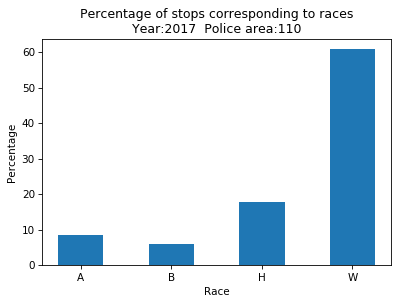

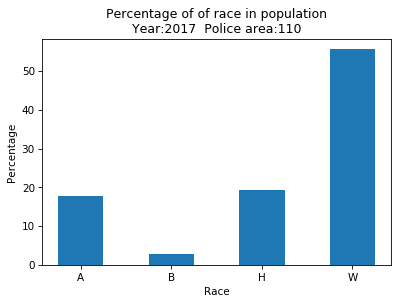

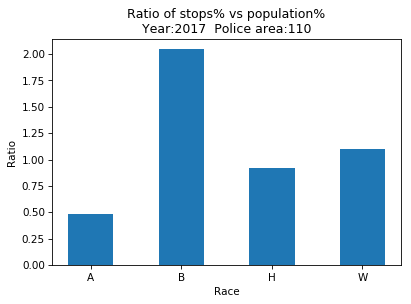

In [50]:
graph_all('110','2017')

#### Processed data for police area 320 in 2015

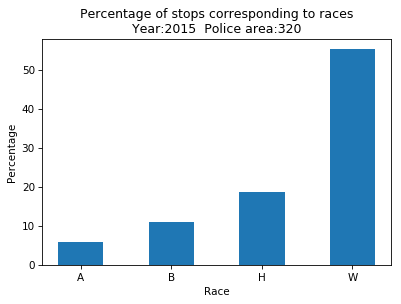

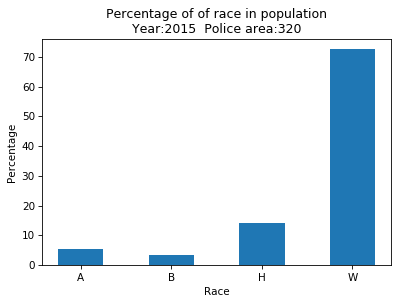

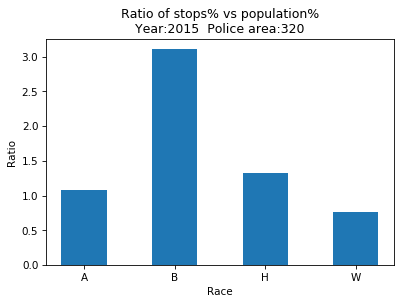

In [51]:
graph_all('320','2015')

#### Processed data for police area 720 in 2014

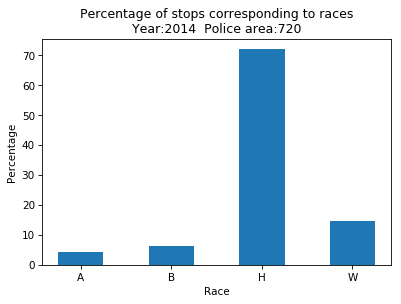

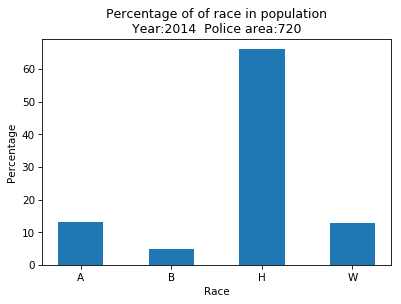

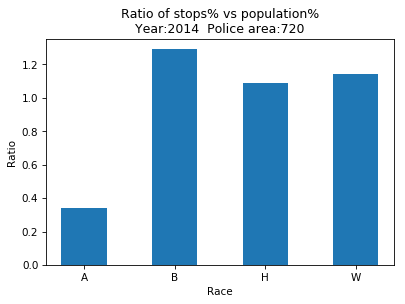

In [52]:
graph_all('720','2014')

### -> Analysis and results

Above, we plotted three different sets of graph from different police areas and years. The trends that we see for the plotted data matches what we see in the rest of our dataset.
The first two graphs, that is the stops and population percentages associated with each race are always very similar. Above, the two graphs are extremely similar in shape and value.
The third graph however shows the ratio of the previous two for each race, outlining that some races are stopped more than others compared to their population percentages. Like we see in the first two sets of graphs, the third graph shows a large ratio between stops and population percentages for the Black population. It is true that in almost all areas of San Diego, Blacks form a very small percentage of stops and actual population, and that this means that any minor discrepancy will result in a large ratio (If only 1% of the population is Black and 2% of the stops correspond to Black people, the ratio of the two will be of 2, which will sem very high compared to that if Whites for example, whose percentages are much greater). While a large ratio between the first two graphs in a given area might not tell us much, we must note that in about 80% of the areas, the ratio corresponding to the Black population is much higher than other races', that Hispanic and White ratios are mostly surrounding a value of 1, and that the ratio for the Asian tends to be lower than the rest. However, not all areas show this trend, if we look at the last set of graphs, we can see that the stops% vs population% ratios are very close to 1, showing that the stops and population graphs are almost identical.

## -> Visualization and analysis of ratios in all police areas

Ratio of stops% vs population% for all police area codes in 2017. Bars represent percentage for Asian, Black, Hispanic, and White populations respectively. Each graph has the data for a different police area in 2017

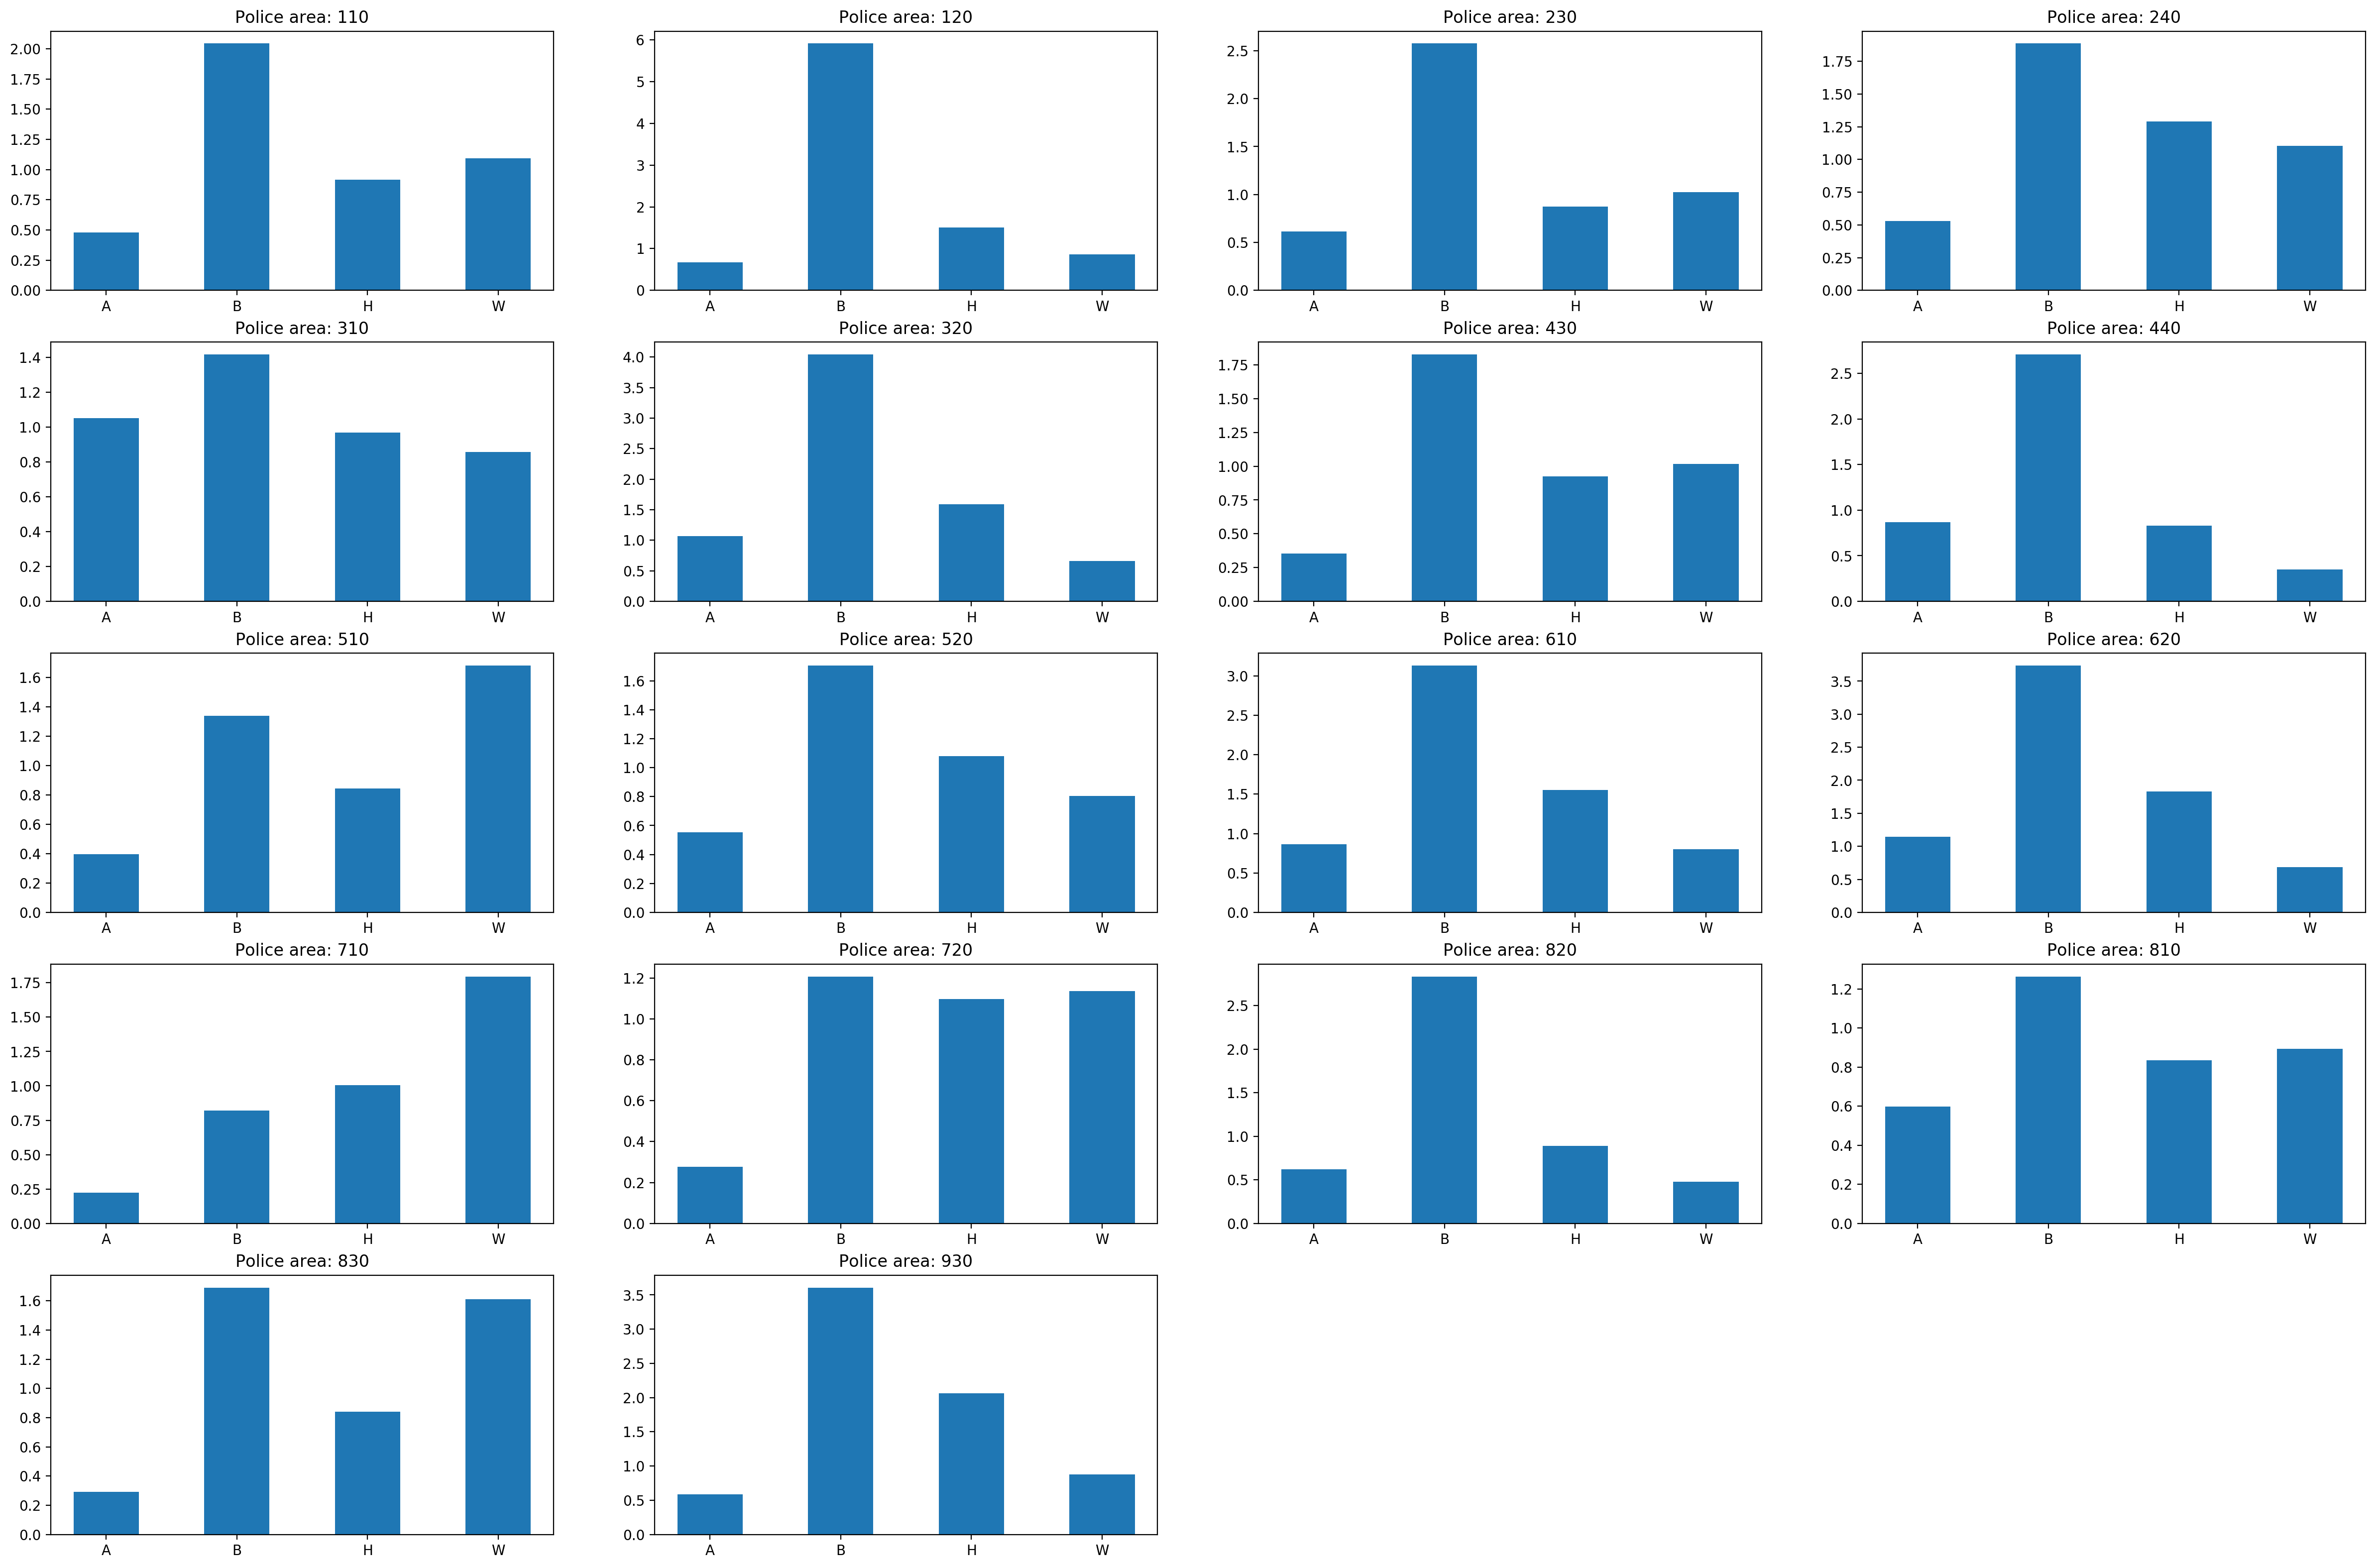

In [53]:
stops_vs_population_plot_all('2017')

### -> Analysis and results

Based on the graphs above we can see the previously mentioned trend. While the exact ratios are now shown here, it is obvious that relative to the other races, the ratio of stop% vs population% is greater for Backs and lower for Asians. The census population we are using is from 2010, and much could have happened over the years changing the value of our ratio, so we cannot determine that a higher ratio of stops for Black drivers means police racial bias. Driver behaviors may be the cause of this, our data can neither deny nor confirm this but Asians might carpool more than Blacks, which would result in a much smaller ratio, again, this is not necessarily the case but just an analysis of how other factors could be affecting our results. Here we can also see that while it is not as high as the ratio for the Black population, the ratio for Hispanics is between 1.5 and 2 in over half of the districs. Again, this could be due to population changes since 2010 but in the graphs below we will see that the trend has been happening since 2014 without changing much, meaning that the dataset is unlikely to have changed tremendously since 2010. 

## -> Visualization and analysis of ratios throughout the years

The graphs below print the same ratio information than the bar graphs before but from all 4 years. This shows not only that the trends described before occur in all four years, but that it has not changed much throughout this time. If you connect the colored dots together throughout the years, in most cases you would get a horizontal line, meaning that the stops to population ratio has not changed much. 

#### Legend
- Asian (Gold)
- Black (Blue)
- Hispanic (Green) 
- White (Red)

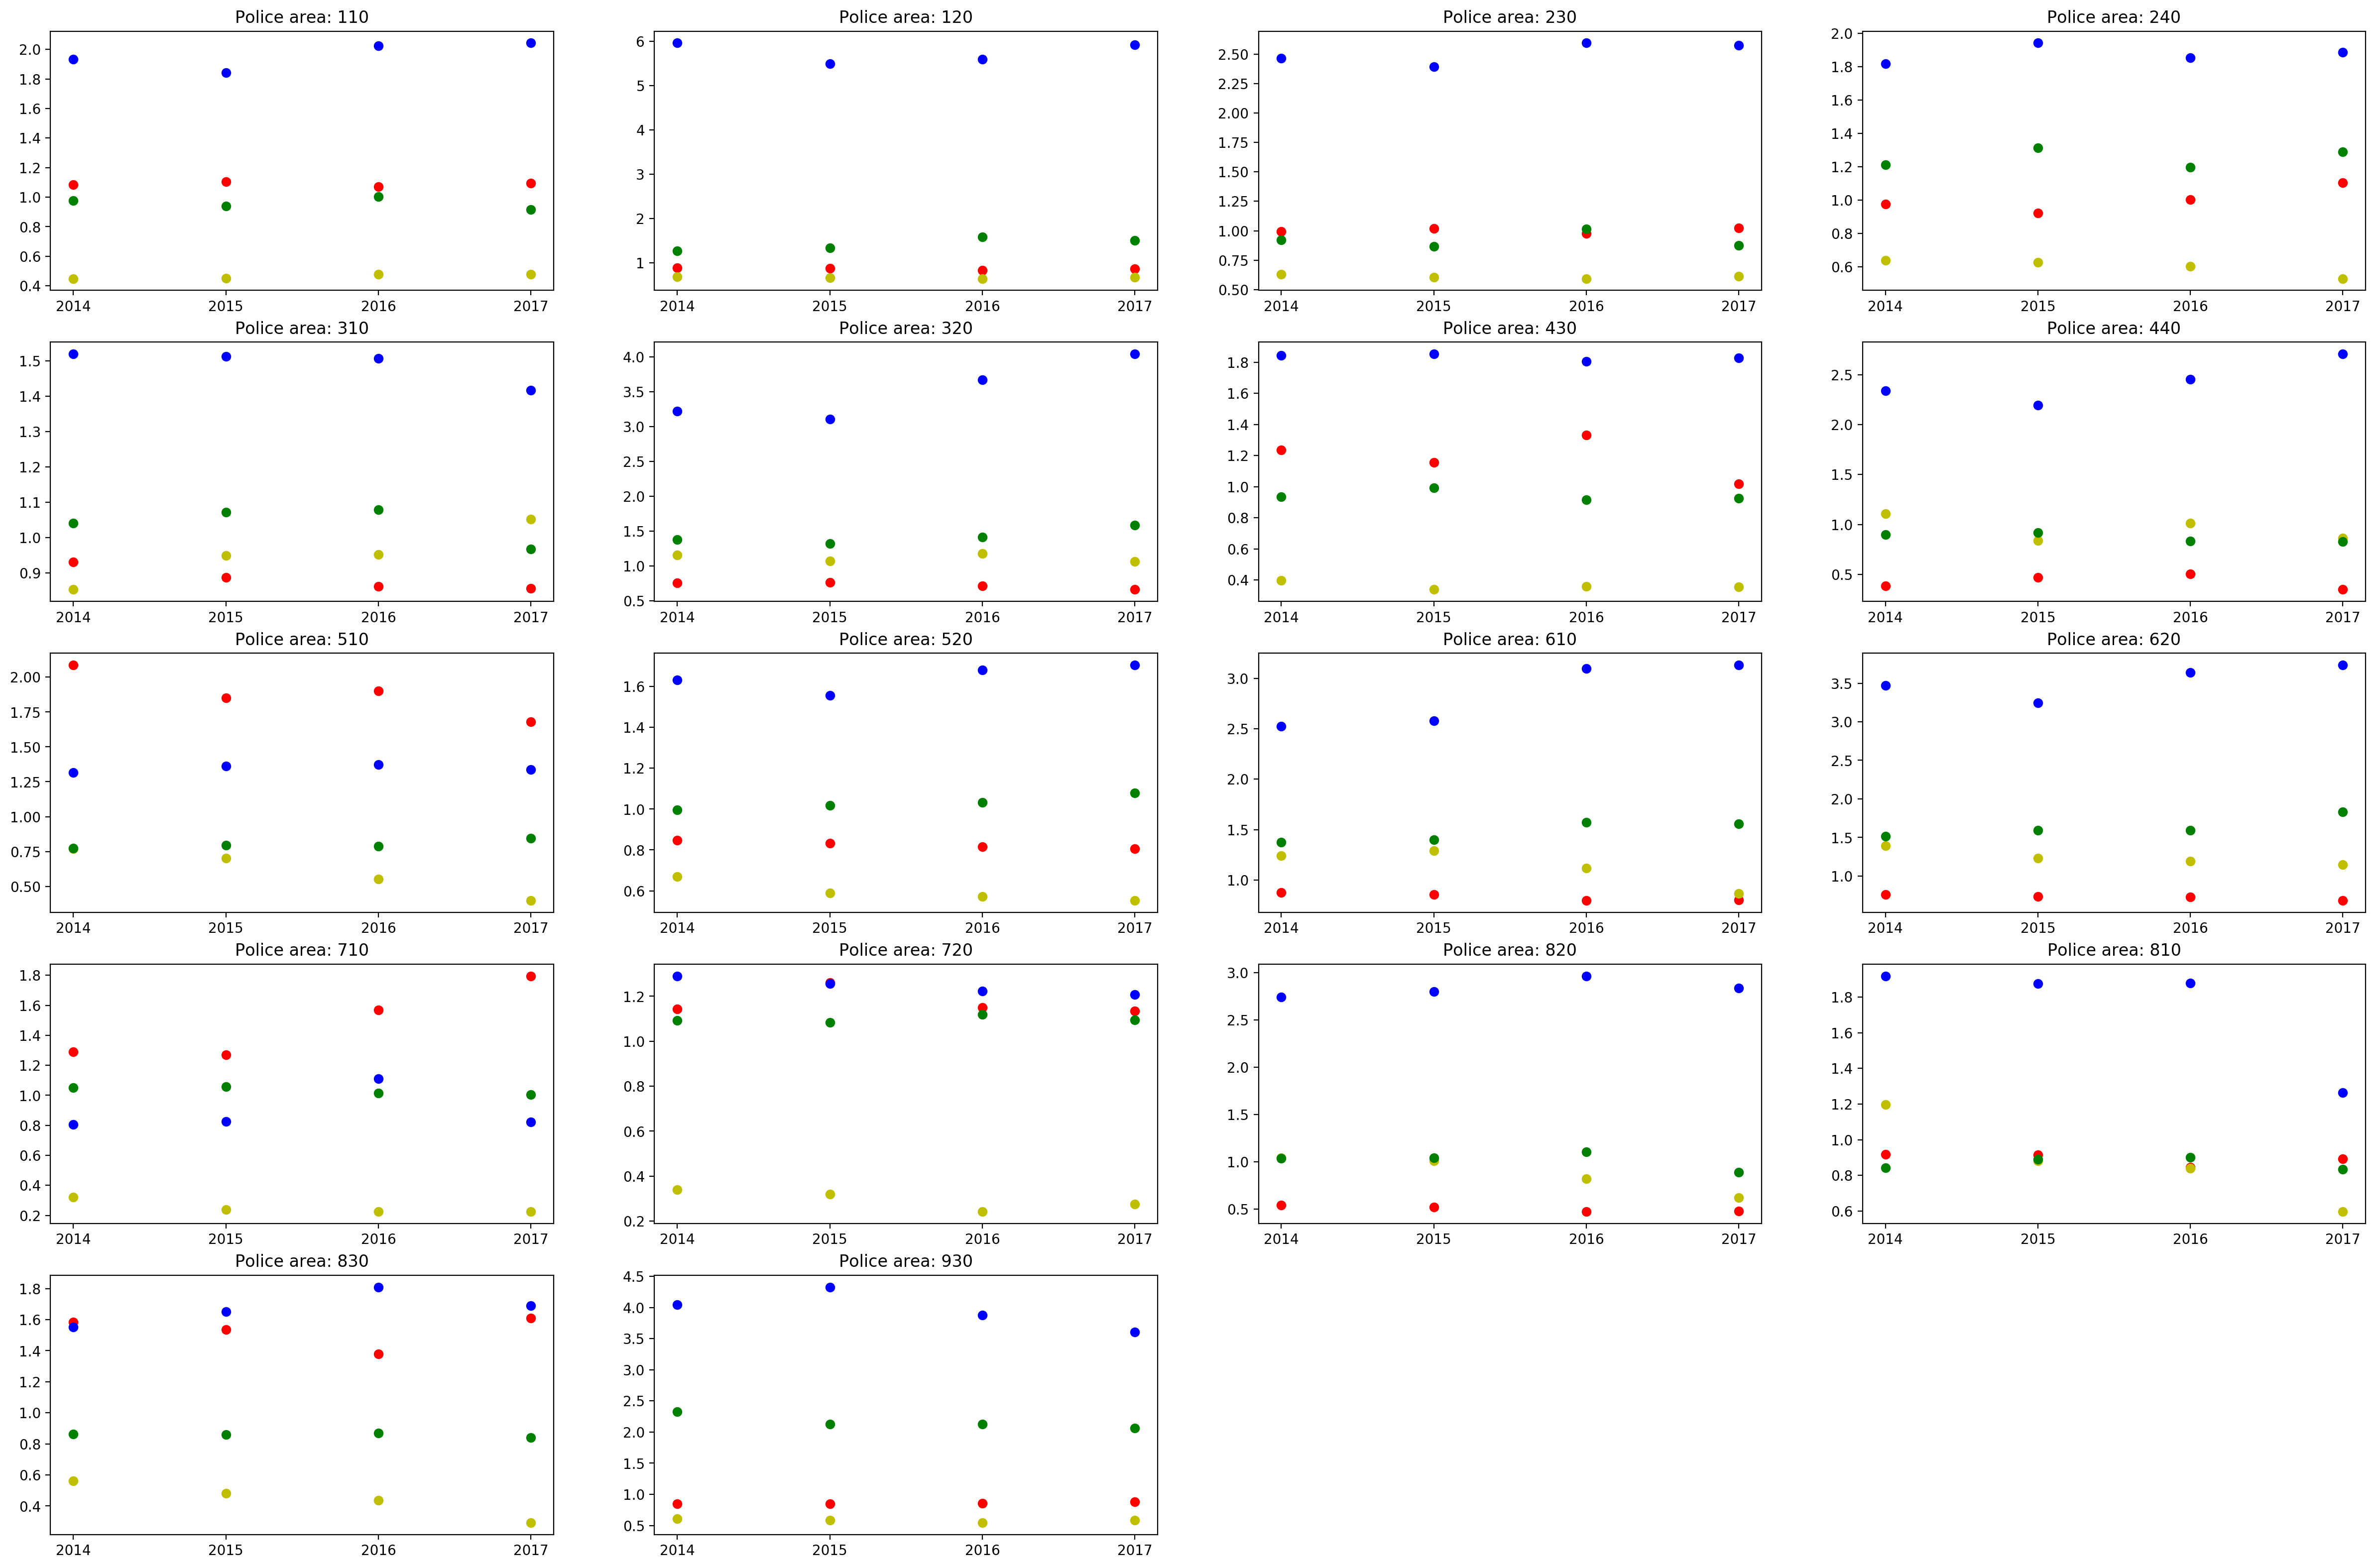

In [54]:
correlation_over_years()

### -> Analysis and results

Here we come accross a new result. Since 2014, our research showed that the police has been under more and more pressure due to accusations of bias. Here we are not claiming a bias exist, since our data might be affected by other factors such as population percentages per area not being a good match to driver populations per area, however, we do see that much has not changed over the last 4 years, the ratios are almost the same which means that if any policies or pressure meant to change police stops based on race, it did not majorly affect our results. Nevertheless, a few police areas do show different trends, police area 710 (column 1 row 4), shows an increase of stops% to population% in the White population while a decrease in the Black population over the last 4 years. This might be due to a change in mentality of cops in the area, population changes, or other totally different reasons. However, police area 710 might have made some changes in 2016 and 2017 that we do not of and have given different ratio results. If this is the case oour analysis could be used by the San Diego police and maybe show a greater insight into the effect of their actions.

## -> Overall section analysis

In general, we can see that our data shows that Blacks are pulled over more (percentage wise) in comparison to the actual area population. However, the stops and population percentage distributions appear to be very similar in almost every area. We cannot conclude that either of this observations show a bias in the San Diego police body. Like we mentioned previously, the discrepancy in populations could be affected by percentages being too small, or by the fact that our population percentage comes from the 2010 San Diego census, and since then the population could have changed it could have altered our results. Still, the trends are clear and we can see that they have not changed over the years, which intales that if there is a problem present, AKA if there is an actual bias and things have been done/policies have been put into place to avoid these biases, the percentage of stops per race has not seemed to change throughout the last 4 years in San Diego.

## -> Interactable Map

More visual way to analyze and interact with the data. The code below places markers at the center of each police area.

In [55]:
# Function: access a dictionary of geo-coordinates that are at the approximate center of police districts
# Params: police_district - police area whose location we want to access
# Return: Coordinates corresponding to center of given police area
def get_area_markers(police_district):
    marker_coord_dict = {
                '110': [32.817843,-117.183983],
                '120': [32.831824,-117.260618],
                '130': [0,0],
                '230': [32.99341,-117.082936],
                '240': [32.878529,-117.082583],
                '310': [32.810546,-117.127871],
                '320': [32.801558,-117.055771],
                '430': [32.701655,-117.054581],
                '440': [32.704123,-117.095650],
                '510': [32.713665,-117.138719],
                '520': [32.720254,-117.166732],
                '530': [0,0],
                '610': [32.735465,-117.239009],
                '620': [32.773399,-117.174370],
                '630': [0,0],
                '710': [32.550827,-117.028451],
                '720': [32.579134,-117.071392],
                '810': [32.747695,-117.129622],
                '820': [32.760502,-117.082755],
                '830': [32.734390,-117.097712],
                '840': [0,0],
                '930': [32.922047,-117.201754],
                'Unknown': [0,0]
                }
    return marker_coord_dict[police_district]

In [56]:
# Function: Gets the average ratios of stops between groups in a police district across all 4 years
# Param: police_district - police area we wish to look into
# Returns: Average ratio of police district
def get_general_ratios(police_district):
    ratios = list()
    for race in races:
        ratio_sums = 0.0
        for year in years_list:
            ratio_sums += race_compare(police_district, race, year)
        ratios.append(np.divide(ratio_sums, 6.0))
    return ratios

In [57]:
# Function: Creates a bar chart for the ratios of stops in a given police district
# Param: police_district - police area we wish to look into
# Returns: bar graph of ratios of corresponding police area
def create_chart(police_district):
    df_ratios = pd.DataFrame(columns = {'ratios'})
    df_ratios['ratios'] = get_general_ratios(police_district)
    df_ratios.index = races
    bar = vincent.Bar(df_ratios['ratios'])
    bar.axis_titles(x='Race',y='Police Stop Ratio at ' + police_district + ' Districts')
    return bar

In [58]:
# Function: Puts a graph on a marker at a specified lattitude and longitude on a map
# Params: graph - the graph to be displayed at marker
#         lat - latitude of marker location
#         lon - longitude of marker location
#         display_map - Map where the graph and marker will be displayed
def put_on_map(graph, lat, lon, display_map):
    graph.width = 400
    graph.height = 210
    graph.to_json('temp.json')
    folium.RegularPolygonMarker(
        [lat,lon],
        fill_color='#FF0000',
        radius= 12,
        number_of_sides=6,
        popup= folium.Popup(max_width=450).add_child(
            folium.Vega(json.load(open('temp.json')), width=450, height=250))
        ).add_to(display_map)

In [59]:
# Function: Creates markers on a display map
# Param: display_map - map that will hold markers and display data
def create_markers(display_map):
    for area in areas_with_data:
        put_on_map(create_chart(area), get_area_markers(area)[0], get_area_markers(area)[1], display_map)

#### Map
Click on the stop signs to see graphs of average stopping ratios from the last 4 years for different races. Colorized areas are the police divisions, while individual districts are separated further (not legible due to limitations of jupyter notebook iopub data rate limits).

In [60]:
# Create a folium map
m1 = folium.Map(location=[32.808,-117.153], zoom_start=10)

# Read in the edited image of the police districts, convert to numpy array
image = io.imread('https://image.ibb.co/jDnLNx/imageedit_2_9619084790.png')

#Add an overlay of the police district map to the folium map
m1.add_child(
plugins.ImageOverlay(
    image= image,
    bounds = [[32.530,-117.286],[33.114,-116.896]],
    opacity = 1.0,
))
create_markers(m1)
m1


This is what the map above would look like

#### Map Visual

<img src="map_display_1.png" width="3000px">

<img src="map_display_2.png" width="3000px">

#### Locations close to the south

<img src="map_display_3.png" width="3000px">

<img src="map_display_4.png" width="3000px">

### -> Map Analysys and results

When clicked, the markers display the stops% vs population% ratio graph, averaged over the last 4 years. The graph can give you an insigtht of what is going on in your area of interest. For exaple, the areas very close to the border, both present correlations where all races (except asian) have a ratio of stops% vs population% very close to 1. Both of those areas have very similar ratio data, which could indicate that they have similar driver/police behaviors which result in corresponding correlation data. These areas close to the border are far from the other ones, which could indicate that their police body is/acts different, which could be the reason behind their ratio graphs being so much different than the rest.

## -> Based on race, how likely is someone to get a citation, get arrested, etc. ?

Let's take the total amount of times a certain race is stopped and divide it by the amount of times they receive a certain police action with the following functions.

In [61]:
# Function: Calcuates what percentage of people in a population receive a certain action if they get pulled over
# Params: year - year we ar looking into
#         race - race of population we want to analyze
#         action - action whose percentage we wish to compute
def race_for_action(year,race,action):
    race_citation_total = 0
    race_stops_total = 0


    for index, row in years[year].iterrows():
        
        desc = row['search_details_description']
        ra = row['subject_race']
        if (race is not np.nan) & (ra == race):
            race_stops_total +=1
            if (desc is not np.nan):
                for item in desc:
                    if item == action:
                        race_citation_total += 1
    
    if race_stops_total == 0:
        return 0
    
    else:
        return race_citation_total/race_stops_total *100

In [62]:
# Function: Calcuates what percentage of people in a population receive a 
#           certain action if they get pulled over for all actions and races
# Params: year - year we wish to look into
# Return: returns a dataframe with all of the above information
def calculate_race_for_all(year):
    
    percentages = pd.DataFrame()
    percentages = pd.DataFrame(columns = ['A','W','B','H'])
    percentages['Action'] = observed_actions
    percentages.set_index('Action', inplace=True)

    for index, row in percentages.iterrows():
        for race in ['A','W','B','H']:
            percentages.loc[index,race] = race_for_action(year,race,index)
    return percentages


In [63]:
# Compute results using functions above
percent_per_race_2017_df = calculate_race_for_all('2017')

In [64]:
# Compute results using functions above
percent_per_race_2016_df = calculate_race_for_all('2016')

In [ ]:
# Compute results using functions above
percent_per_race_2015_df = calculate_race_for_all('2015')

In [ ]:
# Compute results using functions above
percent_per_race_2014_df = calculate_race_for_all('2014')

Below is the dataframe that corresponds to police actions and how likely each race is to receive such actions if pulled over. For example, if a given person is Hispanic and gets pulled over, they have a 54.6804% chance of receiving a citation and a 1.10454% chance of getting arrested based on the stops data from 2017. 

In [ ]:
percent_per_race_2017_df

We can plot this data for different police actions to get a visual comparison between races

In [ ]:
def plot_race_for_action(year,action):
    perc = list()
 
    if year == '2017':
        percent_df = percent_per_race_2017_df
        
    elif year == '2016':
        percent_df = percent_per_race_2016_df
        
    elif year == '2015':
        percent_df = percent_per_race_2015_df
        
    elif year == '2014':
        percent_df = percent_per_race_2014_df
    
    for race in races:
        perc.append(percent_df.loc[action,race])

    plt.figure(figsize=(6, 4), dpi=75)
    plt.title('Likelihood of \''+action+'\' for each race in '+year)
    plt.xlabel('Race')
    plt.ylabel('Percentage')
    plt.bar(races,perc, width=.50)
    plt.show()

In [ ]:
plot_race_for_action('2017','citation')
plot_race_for_action('2016','citation')
plot_race_for_action('2015','citation')
plot_race_for_action('2014','citation')

In [ ]:
plot_race_for_action('2017','arrest')
plot_race_for_action('2016','arrest')
plot_race_for_action('2015','arrest')
plot_race_for_action('2014','arrest')

### -> Analysys and results

Other than arrests and citations, the rest of police actions do not happen often enough to ha a meaningful comparison (if towing only happens under 0.01% for each race, a difference in percentages will ve very insignificant). 

Above we plotted how likely each race is to get a citation or arrested when getting pulled over for every year. We have over 20,000 observations per year so the numbers are quite accurate and representative of the population. For citations, while there is some discrepancy, all percentages surround 50%. Here the data does not show a notable difference in citation chance per race.  One interesting fact to note is that while Blacks have the depressed rates of getting citations, they have an elevated chance of being arrested. Furthermore, while the likelihood of receiving a citation remains stable through all for year for every race, the chances of being arrest changes in an interesting way year by year; the percent of Hispanics and Whites being arrested seems to subtly drop every year, while at the same time rising for Blacks. A claim of racial bias against the police was made in 2016, and any systems they may have implemented since then do not seem to have had a significant effect on the Black population.

# [ Privacy and Ethics ]

We obtained our police stop data from https://data.sandiego.gov/datasets/police-vehicle-stops/ and by the license described at the bottom section of the page, we have permission to use these public sets of data. It is emphasized that there are no restrictions when it comes to using the data on this website to share and create tools. We obtained our population data from www.sandag.org/, and the website’s terms of use states they reserve the right to remove our work if we violate any of their socia media guidelines (posting it on social media), given we did not do this, these terms do not apply to us. Also, their privacy policy guarantees confidentiality, and we can attest to that, since the data we obtained from them included no personal data or data that could be traced back to anyone. None of the police and population datasets provide personal information and all subjects remain anonymous beyond the point of gender, age, and race. www.sandag.org/ obtains their data from the U.S. census conducted every 10 years by the federal government, so we believe there is no bias in the methods used to collect this data. Based on our datasets and what we did with the information, we believe that we did not violate any conditions concerning privacy or ethical misconduct, we did not include any extra information or associated the data to any particular person or persons. We also made sure none of our data included individuals over 90 years old (looked at code below). We are following the guidelines outlined by the Safe Harbor Method, we include police areas but they are formed by multiple zipcodes with much more than 20,000 residents, and they are not linked to any individual/s, we do not include any sort of vehicle identification numbers, biometric identifiers, or plate numbers. None of the date we are using can be traced back to anyone nor we are adding anything to do so, or associating it with any group of people. Police officer information are also kept private and we have no access to it. Adding to this we want to clarify that any conclusions that we come up with are solely based on what the data we analyzed shows, and we are in no way accusing the San Diego Police Department of any form of racial prejudice, since there are other factors that may be the reason behind our results. We kept privacy and ethics a primary concern within our data analysis and ensured that the information we came up with complies with the ethics of data science.

In [ ]:
for i in range(90,120):
    assert(len(df_merged_17[df_merged_17['subject_age'] == i])==0)
    assert(len(df_merged_16[df_merged_16['subject_age'] == i])==0)
    assert(len(df_merged_15[df_merged_15['subject_age'] == i])==0)
    assert(len(df_merged_14[df_merged_14['subject_age'] == i])==0)
print('Passed')

# [ Conclusions and Discussion ]

For our project we wanted to compare the likelihood of each race being pulled over to their population size. When we realized that the police reports were written by police district we grouped each race by their population per zip code. This way, instead of looking at San Diego’s overall population we could concentrate on certain police districts, which would be more informative.

In our interactive map and graphs we looked at the ratio of stops percentage vs. population percentage per race, that is, we looked at whether the stops distribution was significantly different to the population distribution. Such ratio, was much higher for Blacks and Hispanics in over half of the districts in comparison to Asians and Whites. This appeared to be consistent throughout all four years of research available.

While this above is true, something we realized in our data is that the percentage of each race being pulled over is almost the same as the total population percentage in that district. This may explain why blacks may appear to be more likely to get pulled over. blacks make up less than 10% of the population in most San Diego districts, so any amount of pulled over black drivers would greatly increase their likelihood. The fact that the percentages are about the same may indicate that police officers are consistent with who they pull over.

From our data it seems that there may not be a definitive police racial bias. We believe that the low amount of blacks per police district increases the sensitivity of black percentage being pulled over and that a bias did not seem apparent when looking at percentage of citations per race. However, Blacks did show to be much more likely to be arrested if stopped, which suggests further research. 

Overall there are various other variables that could influence a potential racial bias, such as the type of police action or the gender/age of the driver. We also understand that the census is from 2010, which may not be accurate of the actual population in San Diego at that time.

It should be noted that our project is different from what we initially proposed. Initially we wished to compare whether factors such as gender, race, age, or location affected the type of decision that San Diego police made when stopping people. However, we decided to solely focus on race as a factor much more in depth due to the great potential the dataset had to explore this attribute, which is seen in the many ways we analyzed the data and drew conclusions. We also believe that based on the current conversation about police officers and racism, investigating race would have a greater impact to today's conversation than investigating age or gender.

Increased ratios and higher percentages might show an apparent bias from police officers, but we cannot neglect that other factors may be the result behind our data. Some of these factors might include migration and population changes, driving behaviours or reporting errors. What is clear though is that the trends shown throughout the years are constant, they have not seemed to decrease or increase in any notable way, which means that if efforts have been made to change the behaviour of police officers in San Diego when stopping vehicles, they have not had an effect that our analysis can determine. 

The conversation surrounding police stops does not end here, Some differences are very apparent between races, but we did not evalute enough parameters (population changes, income, etc.) to infer racial bias. While more research needs to take place to evaluate the depth of these results, our analysis gives a starting point to the conversation, suggesting that while a bias may still exist, the data does not seem to imply so by itself. 